In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.linalg
import scipy
import copy


# This jupyter notebook has four parts. Only Part I and Part III are related to neural networks.
# Part II and Part IV are just serving to support the argument "representation => generalization".
# For a self-contained simplified version involving only Part I and III, please use toy_model_nn.ipynb

#################### Part I: Hyperparameters ####################
eta1 = 1e-4 # encoder learning rate (gradient)/ representation learning rate (natural gradient)
eta2 = 1e-3 # decoder learning rate
seed = 5 # random seed
input_dim = 10 # dimension of input random vector
latent_dim = 1 # dimension of representation space
output_dim = 10 # dimension of input random vector
p = 10 # base. i,j are integers in {0,1,2,...,p-1}.
epochs = 1 # training iterations
log = 100 # logging frequency
dec_w = 200 # decoder width
wd = 0 # decoder weight decay
train_num = 45 # size of training set, no replacement (full dataset size=p(p+1)/2. 55 for p=10)
modulo = False # If true, o=i+j(mod p); else o=i+j.
natural_gradient = True # If true, use natural gradient; else use the common parameter gradient.

################## Part II: Generate and Analyze the training set ##############
np.random.seed(seed)
torch.manual_seed(seed)

#------------training set-----------#
D0_id = [] # D0 is the full dataset, D0_id=[(0,0),(0,1),...,(p-1,p-1)]. D0 contains p*(p-1)/2 samples.
xx_id = [] # xx_id is the list of i in (i,j) in D0_id. xx_id = [0,0,...,p-1]
yy_id = [] # yy_id is the list of j in (i,j) in D0_id. yy_id = [0,1,...,p-1]
for i in range(p):
    for j in range(i,p):
        D0_id.append((i,j))
        xx_id.append(i)
        yy_id.append(j)
        
xx_id = np.array(xx_id)
yy_id = np.array(yy_id)

all_num = int(p*(p+1)/2)
train_id = np.random.choice(all_num,train_num, replace=False) # select training set id
test_id = np.array(list(set(np.arange(all_num)) - set(train_id))) # select testing set id

#-----------Parallelogram set---------#
P0 = [] # P0 is the set of all possible parallelograms
P0_id = []

ii = 0
for i in range(all_num):
    for j in range(i+1,all_num):
        if np.sum(D0_id[i]) == np.sum(D0_id[j]):
            P0.append(frozenset({D0_id[i], D0_id[j]}))
            P0_id.append(ii)
            ii += 1

P0_num = len(P0_id) # P0_num is the number of elements in P0

#---------Linear Equation set---------#
A = []
eq_id = 0

for i1 in range(P0_num):
    i,j = list(P0[i1])[0]
    m,n = list(P0[i1])[1]
    if i+j==m+n:
        x = np.zeros(p,)
        x[i] = x[i] + 1; 
        x[j] = x[j] + 1; 
        x[m] = x[m] - 1;
        x[n] = x[n] - 1;
        A.append(x)
        eq_id = eq_id + 1

A = np.array(A).astype(int)

# P0(D)
P0D_id = []


#----------Predict testing accuracy with Parallelogram set-------------#
ii = 0
for i in range(all_num):
    for j in range(i+1,all_num):
        if np.sum(D0_id[i]) == np.sum(D0_id[j]):
            if i in train_id and j in train_id:
                P0D_id.append(ii)
            ii += 1

P0D = []
for i in P0D_id:
    P0D.append(P0[i])

# P0D_c
P0D_c_id = set(P0_id) - set(P0D_id)


# PD
PD_id = []

for i in P0D_c_id:
    P0D_id_aug = copy.deepcopy(P0D_id)
    P0D_id_aug.append(i)
    P0D_aug = []
    for j in P0D_id_aug:
        P0D_aug.append(P0[j])
    null_dim_1 = np.sum(np.linalg.eigh(np.matmul(np.transpose(A[P0D_id]),A[P0D_id]))[0] < 1e-8)
    null_dim_2 = np.sum(np.linalg.eigh(np.matmul(np.transpose(A[P0D_id_aug]),A[P0D_id_aug]))[0] < 1e-8)
    if null_dim_1 == null_dim_2:
        PD_id.append(i)

PD_id = PD_id + P0D_id

PD = []
for i in PD_id:
    PD.append(P0[i])


RQI_ideal = len(PD)/P0_num # This is ideal RQI


# Dbar(D)
Dbar_id = list(copy.deepcopy(train_id))

for i1 in test_id:
    flag = 0
    for j1 in train_id:
        i, j = D0_id[i1]
        m, n = D0_id[j1]
        if {(i,j),(m,n)} in PD:
            flag = 1
            break
    if flag == 1:
        Dbar_id.append(i1)

# accuracy in the ideal case. acc_ideal: the whole dataset; acc_ideal_test: only testing set.
acc_ideal = len(Dbar_id)/all_num
acc_ideal_test = (len(Dbar_id)-len(train_id))/len(test_id)

print("acc_ideal_test={}/{}={}".format((len(Dbar_id)-len(train_id)), len(test_id), (len(Dbar_id)-len(train_id))/len(test_id)))


################### Part III: trainining neural networks ######################


# inputs
x_templates = np.random.normal(0,1,size=(p, output_dim)) # input random vectors
if modulo == False:
    y_templates = np.random.normal(0,1,size=(2*p-1, output_dim)) # output random vectors
else:
    y_templates = np.random.normal(0,1,size=(p, output_dim)) # output random vectors
    
x_templates = torch.tensor(x_templates, dtype=torch.float, requires_grad=True)
y_templates = torch.tensor(y_templates, dtype=torch.float, requires_grad=True)

# labels
inputs_id = np.transpose(np.array([xx_id,yy_id]))
if modulo == False:
    out_id = (xx_id + yy_id)
else:
    out_id = (xx_id + yy_id) % p
    
# training set
labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)
inputs_train = torch.cat([x_templates[xx_id[train_id]],x_templates[yy_id[train_id]]], dim=1)
out_id_train = out_id[train_id]

# testing set
labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)
inputs_test = torch.cat([x_templates[xx_id[test_id]],x_templates[yy_id[test_id]]], dim=1)
out_id_test = out_id[test_id]

# Define neural networks
class NET(nn.Module): # base MLP model
    def __init__(self, input_dim, output_dim, w=200):
        super(NET, self).__init__()
        self.l1 = nn.Linear(input_dim, w)
        self.l2 = nn.Linear(w, w)
        self.l3 = nn.Linear(w, output_dim)

    def forward(self, x):
        f = torch.nn.Tanh()
        self.x1 = f(self.l1(x))
        self.x2 = f(self.l2(self.x1))
        self.x3 = self.l3(self.x2)
        return self.x3

class DEC(nn.Module): # Decoder
    def __init__(self, input_dim, output_dim, w=200):
        super(DEC, self).__init__()
        self.net = NET(input_dim, output_dim, w=dec_w)

    def forward(self, latent, x_id):
        self.add1 = latent[x_id[:,0]]
        self.add2 = latent[x_id[:,1]]
        self.add = self.add1 + self.add2 # addition in representation space
        self.out = self.net(self.add)
        return self.out


class AE(nn.Module):
    def __init__(self, w=200, input_dim=1, output_dim=1):
        super(AE, self).__init__()
        self.enc = NET(input_dim, latent_dim, w=w)
        self.dec = DEC(latent_dim, output_dim, w=w)

    def forward(self, x, x_id):
        self.latent = self.enc(x)
        self.out = self.dec(self.latent,x_id)

        return self.out


model = AE(input_dim=input_dim, output_dim=output_dim, w=200)


if natural_gradient == True:
    latent = torch.nn.parameter.Parameter(model.enc(x_templates).clone())
    optimizer1 = torch.optim.Adam({latent}, lr=eta1)
else:
    optimizer1 = torch.optim.Adam(model.enc.parameters(), lr=eta1)
    
optimizer2 = torch.optim.AdamW(model.dec.parameters(), lr=eta2, weight_decay=wd)


reach_acc_test = False
reach_acc_train = False
reach_rqi = False

### training ###

test_acc_epochs = []
train_acc_epochs = []

for epoch in range(epochs): 

    optimizer1.zero_grad()
    optimizer2.zero_grad()

    # updata model parameters
    outputs_train = model.dec(latent, inputs_id[train_id])
    outputs_test = model.dec(latent, inputs_id[test_id])
    loss_train = torch.mean((outputs_train-labels_train)**2)
    loss_train.backward()
    optimizer1.step()
    optimizer2.step()


    # calculate accuracy based on nearest neighbor
    pred_train_id = torch.argmin(torch.sum((outputs_train.unsqueeze(dim=1) - y_templates.unsqueeze(dim=0))**2, dim=2), dim=1)
    pred_test_id = torch.argmin(torch.sum((outputs_test.unsqueeze(dim=1) - y_templates.unsqueeze(dim=0))**2, dim=2), dim=1)
    acc_nn_train = np.mean(pred_train_id.detach().numpy() == out_id_train) # training acc
    acc_nn_test = np.mean(pred_test_id.detach().numpy() == out_id_test) # testing acc
    acc_nn = (acc_nn_train*train_id.shape[0] + acc_nn_test*test_id.shape[0])/all_num # whole accuract
    test_acc_epochs.append(acc_nn_test)
    train_acc_epochs.append(acc_nn_train)

    # check if accuracy reaches a threshold (grokking time)
    if not reach_acc_train: # train
        if acc_nn_train >= 0.9:
            reach_acc_train = True
            iter_train = epoch
            
            
    if not reach_acc_test: # test
        if acc_nn_test >= 0.9:
            reach_acc_test = True
            iter_test = epoch

    # Count parallelograms in representation 
    PR = []
    PR_id = []
    if natural_gradient == False:
        latent = model.enc(x_templates).clone()
    latent_scale = latent/torch.std(latent,dim=0).unsqueeze(dim=0)
    
    count = 0
    for ii in range(P0_num):
        i, j = list(P0[ii])[0]
        m, n = list(P0[ii])[1]
        dist = latent_scale[i] + latent_scale[j] - latent_scale[m] - latent_scale[n]
        if (torch.mean(dist**2)<0.01):
            PR_id.append(ii)
            PR.append(P0[ii])

    rqi = len(PR)/P0_num

    # check if RQI reaches a high threshold (time scale of representation learning)
    if not reach_rqi:
        if rqi > 0.99:
            reach_rqi = True
            iter_rqi = epoch
        
    # logging
    if epoch % log == 0:
        print("epoch: %d  | loss: %.8f "%(epoch, loss_train.detach().numpy()))

# if fails within compute budget      
if not reach_acc_test:
    iter_test = epoch

if not reach_acc_train:
    iter_train = epoch

if not reach_rqi:
    iter_rqi = epoch


################### Part IV: Postprocessing ######################
# predict accuracy, based on the training set and the real representation
eigs = np.linalg.eigh(np.matmul(np.transpose(A[PR_id]),A[PR_id]))[0]
dof = np.sum(eigs < 1e-8) # degree of freedom of the representation
if dof < p:
    lambda_ = eigs[dof]
    iter_pred = 1/lambda_
    iter_pred_rqi = iter_pred
else:
    iter_pred_rqi = -1

# Dbar(P)
Dbar_id = list(copy.deepcopy(train_id))

for i1 in test_id:
    flag = 0
    for j1 in train_id:
        i, j = D0_id[i1]
        m, n = D0_id[j1]
        if {(i,j),(m,n)} in PR:
            flag = 1
            break
    if flag == 1:
        Dbar_id.append(i1)

acc_pred = len(Dbar_id)/all_num
acc_pred_test = (len(Dbar_id)-len(train_id))/len(test_id)

acc_ideal_test=10/10=1.0
epoch: 0  | loss: 1.01850033 


/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_83400/1988763294.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train = torch.tensor(y_templates[out_id[train_id]], dtype=torch.float, requires_grad=True)
/var/folders/6j/b6y80djd4nb5hl73rv3sv8y80000gn/T/ipykernel_83400/1988763294.py:176: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_test = torch.tensor(y_templates[out_id[test_id]], dtype=torch.float, requires_grad=True)


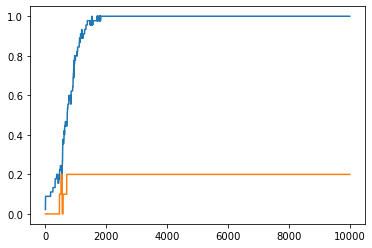

In [2]:
plt.plot(np.arange(epochs), train_acc_epochs)
plt.plot(np.arange(epochs), test_acc_epochs)